[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time, transformer-based object detection model architecture developed by Roboflow and released under the Apache 2.0 license.

![rf-detr-coco-rf100-vl-8](https://media.roboflow.com/rf-detr/charts.png)

RF-DETR is the first real-time model to exceed 60 AP on the [Microsoft COCO benchmark](https://cocodataset.org/#home) alongside competitive performance at base sizes. It also achieves state-of-the-art performance on [RF100-VL](https://github.com/roboflow/rf100-vl), an object detection benchmark that measures model domain adaptability to real world problems. RF-DETR is comparable speed to current real-time objection models.

![rf-detr-coco-results-2](https://media.roboflow.com/rf-detr/example_grid.png)

RF-DETR is small enough to run on the edge, making it an ideal model for deployments that need both strong accuracy and real-time performance.

## Environment setup

### Configure API keys

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Mar 20 16:43:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q rfdetr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

### Download example data

In [3]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

rf-detr-base.pth: 100%|██████████| 355M/355M [00:03<00:00, 105MiB/s]


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights


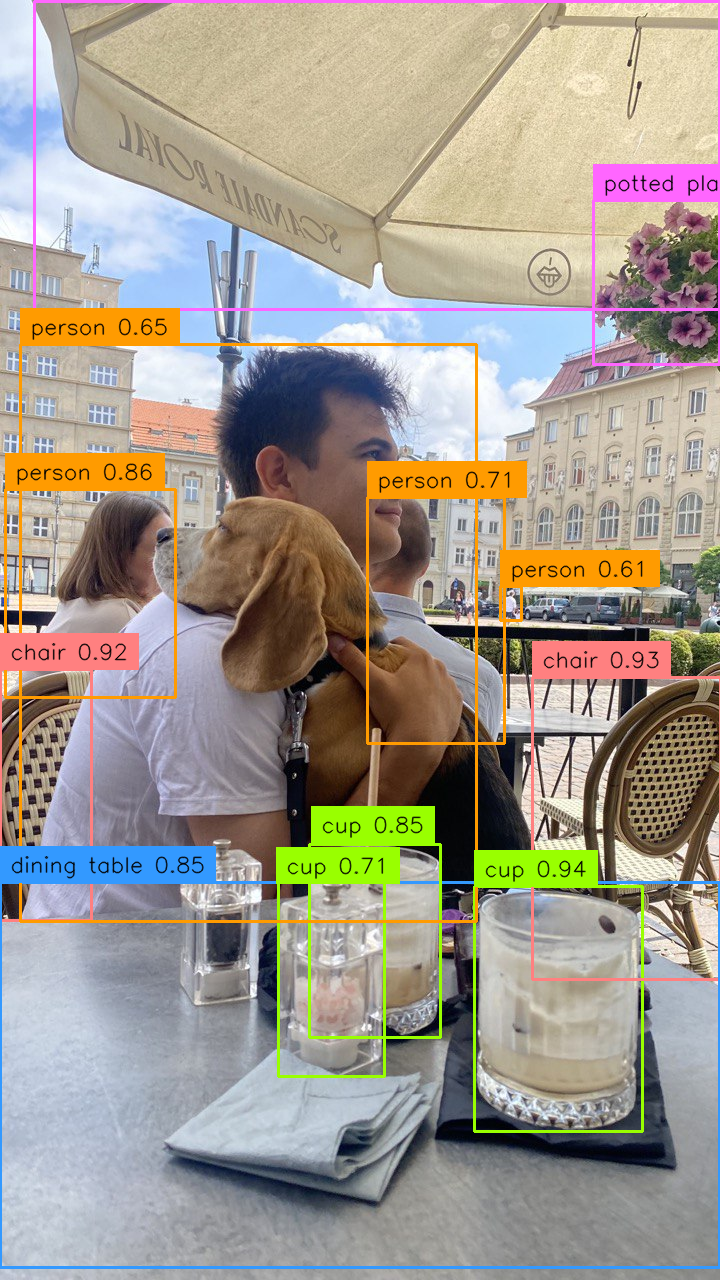

In [4]:
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image

image = Image.open("dog-2.jpeg")

model = RFDETRBase()
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image

## Download dataset from Roboflow Universe

In [5]:
from roboflow import download_dataset
from roboflow import Roboflow
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboteam").project("reeco_mobilessdnet_v2")
version = project.version(2)
dataset = version.download("coco")

#dataset = download_dataset("https://universe.roboflow.com/rf100-vl/mahjong-vtacs-mexax-m4vyu-sjtd/dataset/2", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to reeco_mobilessdnet_v2-2 in coco:: 100%|██████████| 1309/1309 [00:00<00:00, 4654.90it/s]


## Train RF-DETR on custom dataset

In [6]:
from rfdetr import RFDETRBase

model = RFDETRBase()
history = []

def callback2(data):
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(callback2)

model.train(dataset_dir=dataset.location, epochs=15, batch_size=16, grad_accum_steps=1, lr=1e-4)

Loading pretrain weights


reinitializing your detection head with 2 classes.


Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=1, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=15, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16, num_queries=300, group_detr=13, two_stage=True, projector_scale=['P4'], lite_refpoint_refine=True, num_select=300, dec_n_poi

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [ 0/75]  eta: 0:02:54  lr: 0.000100  class_error: 80.22  loss: 13.2402 (13.2402)  loss_ce: 0.8366 (0.8366)  loss_bbox: 1.2491 (1.2491)  loss_giou: 1.1470 (1.1470)  loss_ce_0: 0.8191 (0.8191)  loss_bbox_0: 1.3335 (1.3335)  loss_giou_0: 1.2046 (1.2046)  loss_ce_1: 0.8456 (0.8456)  loss_bbox_1: 1.2595 (1.2595)  loss_giou_1: 1.1430 (1.1430)  loss_ce_enc: 0.8079 (0.8079)  loss_bbox_enc: 1.3600 (1.3600)  loss_giou_enc: 1.2344 (1.2344)  loss_ce_unscaled: 0.8366 (0.8366)  class_error_unscaled: 80.2198 (80.2198)  loss_bbox_unscaled: 0.2498 (0.2498)  loss_giou_unscaled: 0.5735 (0.5735)  cardinality_error_unscaled: 3083.8750 (3083.8750)  loss_ce_0_unscaled: 0.8191 (0.8191)  loss_bbox_0_unscaled: 0.2667 (0.2667)  loss_giou_0_unscaled: 0.6023 (0.6023)  cardinality_error_0_unscaled: 2013.8750 (2013.8750)  loss_ce_1_unscaled: 0.8456 (0.8456)  loss_bbox_1_unscaled: 0.2519 (0.2519)  loss_giou_1_unscaled: 0.5715 (0.5715)  cardinality_error_1_unscaled: 1746.0625 (1746.0625)  loss_ce_enc_unsca

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Test:  [0/5]  eta: 0:00:04  class_error: 0.00  loss: 3.3755 (3.3755)  loss_ce: 0.4844 (0.4844)  loss_bbox: 0.1069 (0.1069)  loss_giou: 0.1810 (0.1810)  loss_ce_0: 0.5781 (0.5781)  loss_bbox_0: 0.1082 (0.1082)  loss_giou_0: 0.1840 (0.1840)  loss_ce_1: 0.5039 (0.5039)  loss_bbox_1: 0.1063 (0.1063)  loss_giou_1: 0.1791 (0.1791)  loss_ce_enc: 0.6172 (0.6172)  loss_bbox_enc: 0.1229 (0.1229)  loss_giou_enc: 0.2035 (0.2035)  loss_ce_unscaled: 0.4844 (0.4844)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.0214 (0.0214)  loss_giou_unscaled: 0.0905 (0.0905)  cardinality_error_unscaled: 6.0625 (6.0625)  loss_ce_0_unscaled: 0.5781 (0.5781)  loss_bbox_0_unscaled: 0.0216 (0.0216)  loss_giou_0_unscaled: 0.0920 (0.0920)  cardinality_error_0_unscaled: 6.0625 (6.0625)  loss_ce_1_unscaled: 0.5039 (0.5039)  loss_bbox_1_unscaled: 0.0213 (0.0213)  loss_giou_1_unscaled: 0.0896 (0.0896)  cardinality_error_1_unscaled: 6.0000 (6.0000)  loss_ce_enc_unscaled: 0.6172 (0.6172)  loss_bbox_enc_unscaled

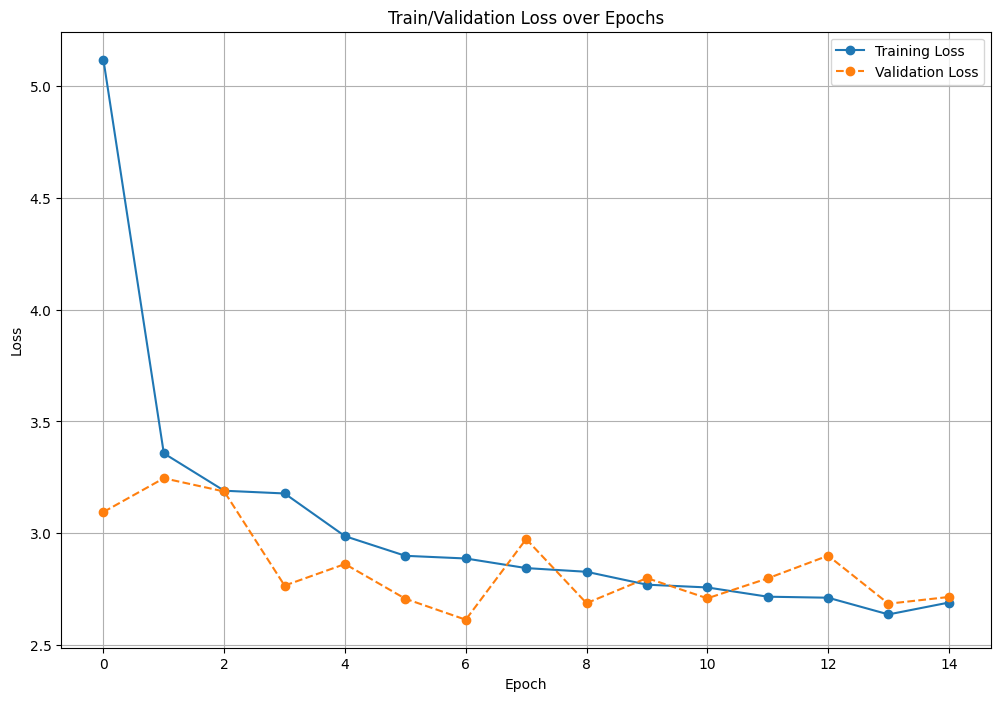

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

plt.figure(figsize=(12, 8))

plt.plot(
    df['epoch'],
    df['train_loss'],
    label='Training Loss',
    marker='o',
    linestyle='-'
)

plt.plot(
    df['epoch'],
    df['test_loss'],
    label='Validation Loss',
    marker='o',
    linestyle='--'
)

plt.title('Train/Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

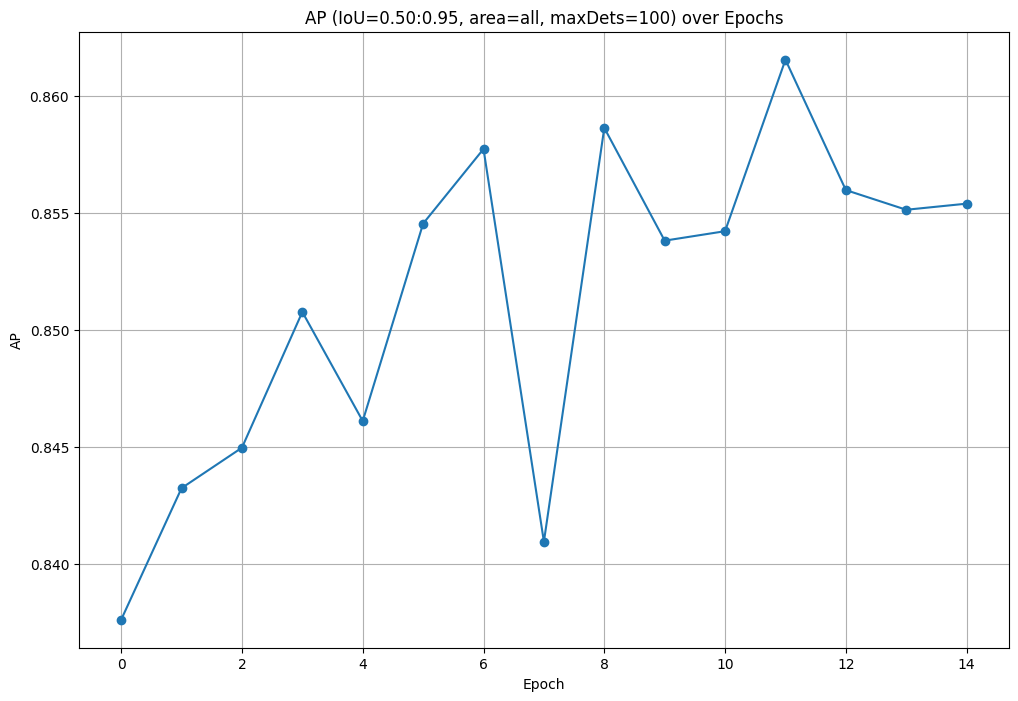

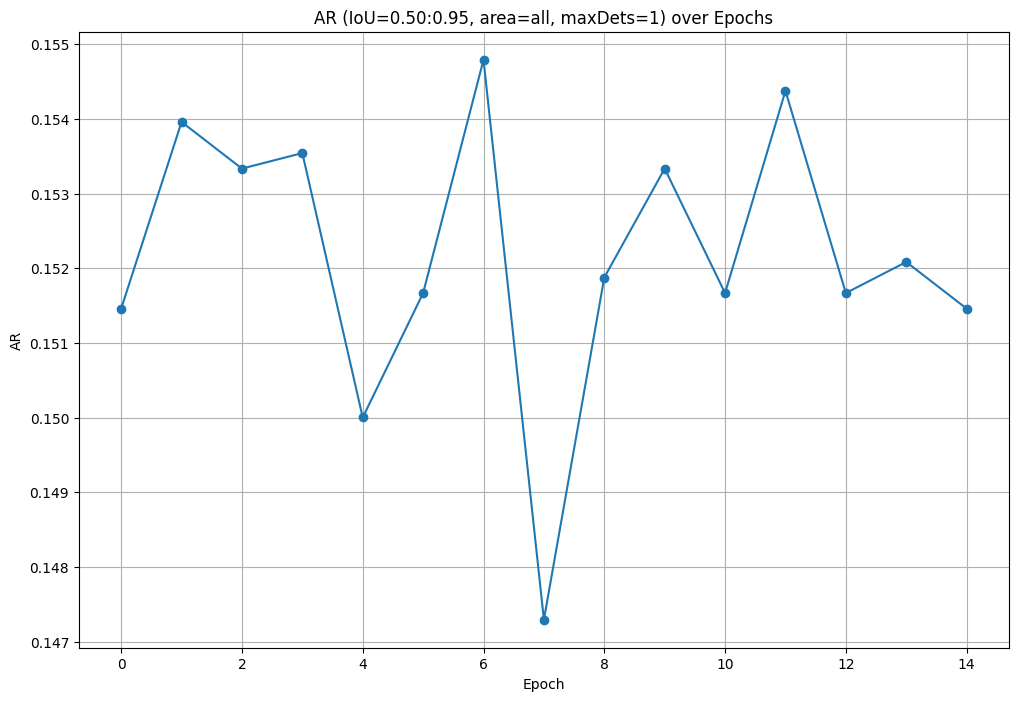

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

df['avg_precision'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[0])
df['avg_recall'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[6])

plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_precision'],
    marker='o',
    linestyle='-'
)
plt.title('AP (IoU=0.50:0.95, area=all, maxDets=100) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_recall'],
    marker='o',
    linestyle='-'
)
plt.title('AR (IoU=0.50:0.95, area=all, maxDets=1) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AR')
plt.grid(True)
plt.show()

## Evaluate fine-tuned model

In [9]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

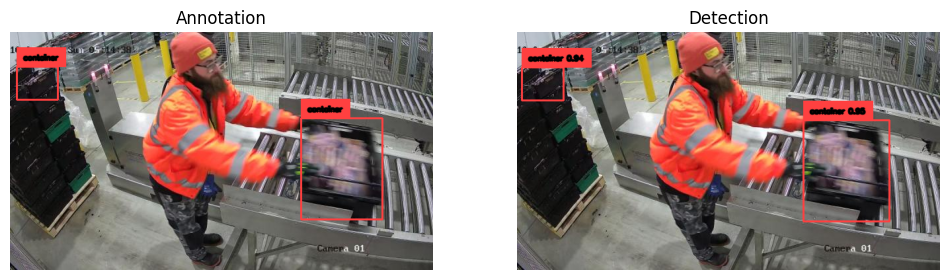

In [10]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

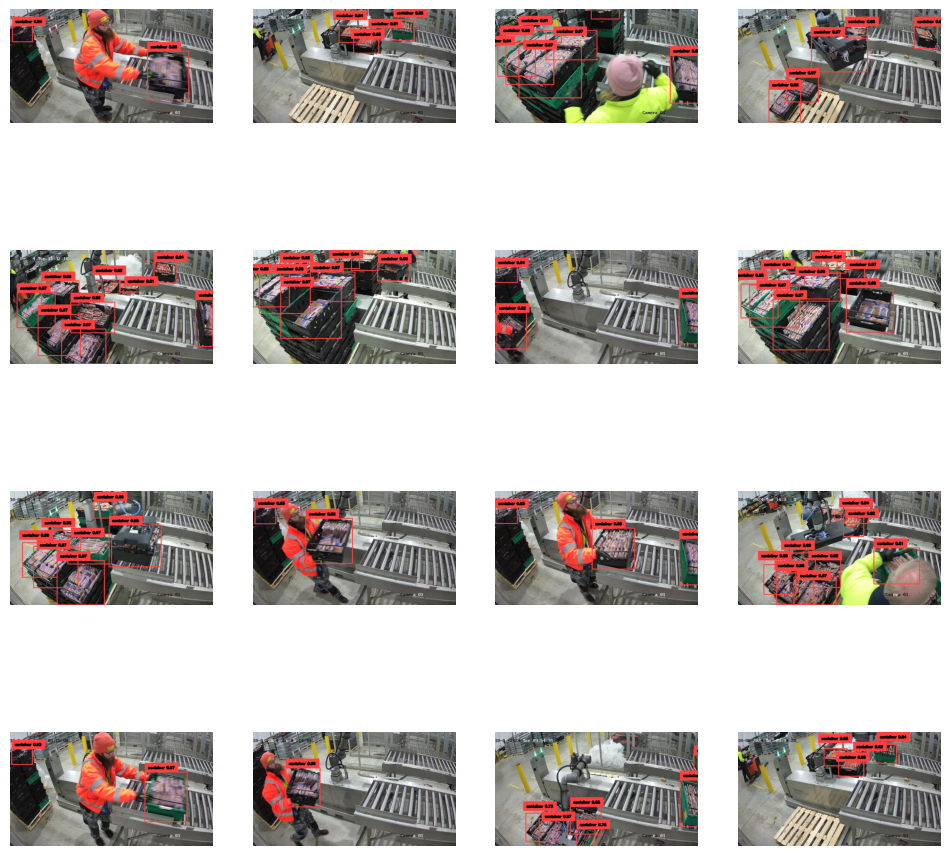

In [36]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(16):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(4, 4))

In [12]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

100%|██████████| 20/20 [00:00<00:00, 34.12it/s]


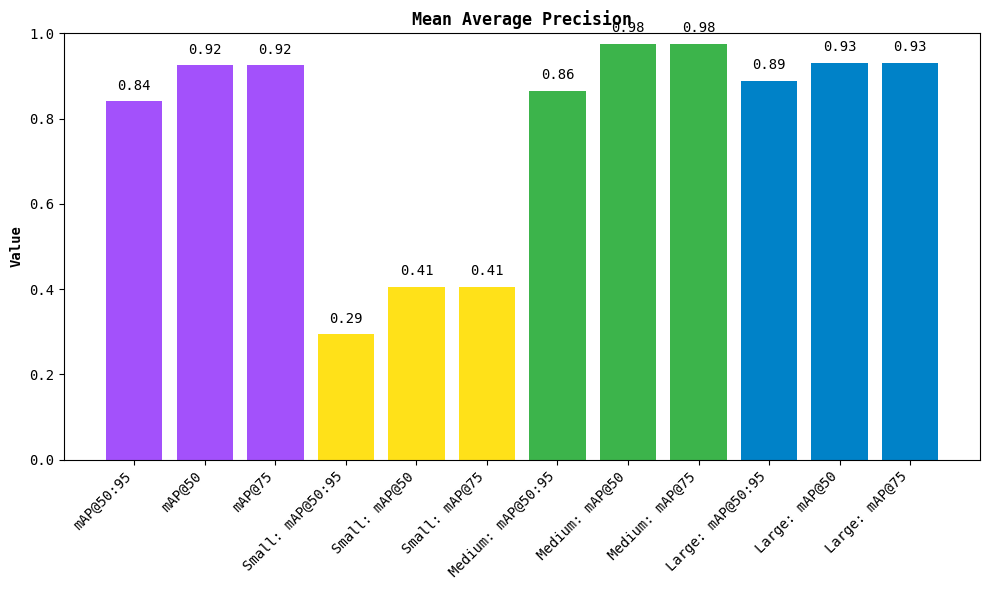

In [13]:
map_result.plot()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
print(dir(model))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'callbacks', 'get_model', 'get_model_config', 'get_train_config', 'maybe_download_pretrain_weights', 'means', 'model', 'model_config', 'predict', 'stds', 'train', 'train_from_config']


In [25]:
methods = [m for m in dir(model) if callable(getattr(model, m)) and not m.startswith("__")]
print("Methods:\n", methods)


Methods:
 ['get_model', 'get_model_config', 'get_train_config', 'maybe_download_pretrain_weights', 'predict', 'train', 'train_from_config']


In [28]:
print(model.get_model_config())

encoder='dinov2_windowed_small' out_feature_indexes=[2, 5, 8, 11] dec_layers=3 two_stage=True projector_scale=['P4'] hidden_dim=256 sa_nheads=8 ca_nheads=16 dec_n_points=2 bbox_reparam=True lite_refpoint_refine=True layer_norm=True amp=True num_classes=90 pretrain_weights='rf-detr-base.pth' device='cuda' resolution=560 group_detr=13 num_queries=300


In [27]:
print("Attributes:\n", model.__dict__)


Attributes:
 {'model_config': RFDETRBaseConfig(encoder='dinov2_windowed_small', out_feature_indexes=[2, 5, 8, 11], dec_layers=3, two_stage=True, projector_scale=['P4'], hidden_dim=256, sa_nheads=8, ca_nheads=16, dec_n_points=2, bbox_reparam=True, lite_refpoint_refine=True, layer_norm=True, amp=True, num_classes=90, pretrain_weights='rf-detr-base.pth', device='cuda', resolution=560, group_detr=13, num_queries=300), 'model': <rfdetr.main.Model object at 0x7bd985178410>, 'callbacks': defaultdict(<class 'list'>, {'on_fit_epoch_end': [<function callback2 at 0x7bd985a171a0>], 'on_train_batch_start': []})}


In [41]:
import torch
import json

In [47]:
# Allow loading of RFDETRBase from a trusted pickle
torch.serialization.add_safe_globals({'RFDETRBase': RFDETRBase})

# Now load the full model
saved_model = torch.load("rfdetr_full_model.pth", weights_only=False)

saved_model.model.model.eval()

LWDETR(
  (transformer): Transformer(
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (cross_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=64, bias=True)
            (attention_weights): Linear(in_features=256, out_features=32, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True

In [49]:
# ✅ Allow the RFDETRBase class to be used when unpickling
torch.serialization.add_safe_globals([RFDETRBase])

# ✅ Now load the full model (weights_only=False is critical)
saved_model = torch.load("rfdetr_full_model.pth", weights_only=False)

# ✅ Set to eval mode
saved_model.model.model.eval()

LWDETR(
  (transformer): Transformer(
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (cross_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=64, bias=True)
            (attention_weights): Linear(in_features=256, out_features=32, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True

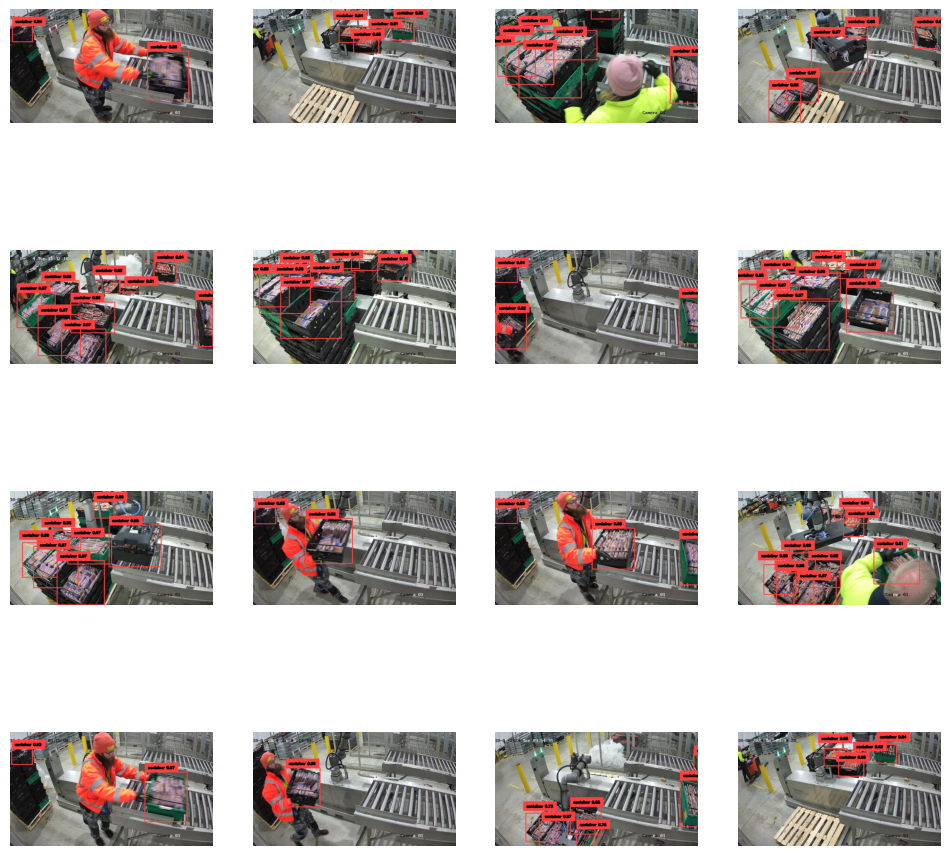

In [50]:

detections_images = []

for i in range(16):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = saved_model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(4, 4))